In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.insert(0, "..")
from src import config, preprocessing, recommender, plots, arxiv_utils, feature_engineering

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF, MiniBatchNMF

The authors category only suggests papers from the same authors and/or groups of authors. However, we would ideally want papers from authors which work on similar topics. So the similarity in question here is not about textual similarity but context similarity.

To do this, we will encode the authors by their most common topics.

## Topic importance

First we encode titles using the encoder described in the previous notebook.

In [4]:
# We start by importing the data
all_df = pd.read_csv(config.path_data_merged)
all_df["published"] = pd.to_datetime(all_df["published"])
all_df_clean = preprocessing.pipeline_arxiv_articles.fit_transform(all_df)

In [5]:
cvSummary = preprocessing.get_tfidf(ngram_range=(1, 2), max_features=1_000, stemming=True)
cvSummary.set_params(max_df=0.95, min_df=2)

Xsummary = cvSummary.fit_transform(all_df_clean["summary"])

We will now try to identify different topics and compare the methods which lead to this classification.

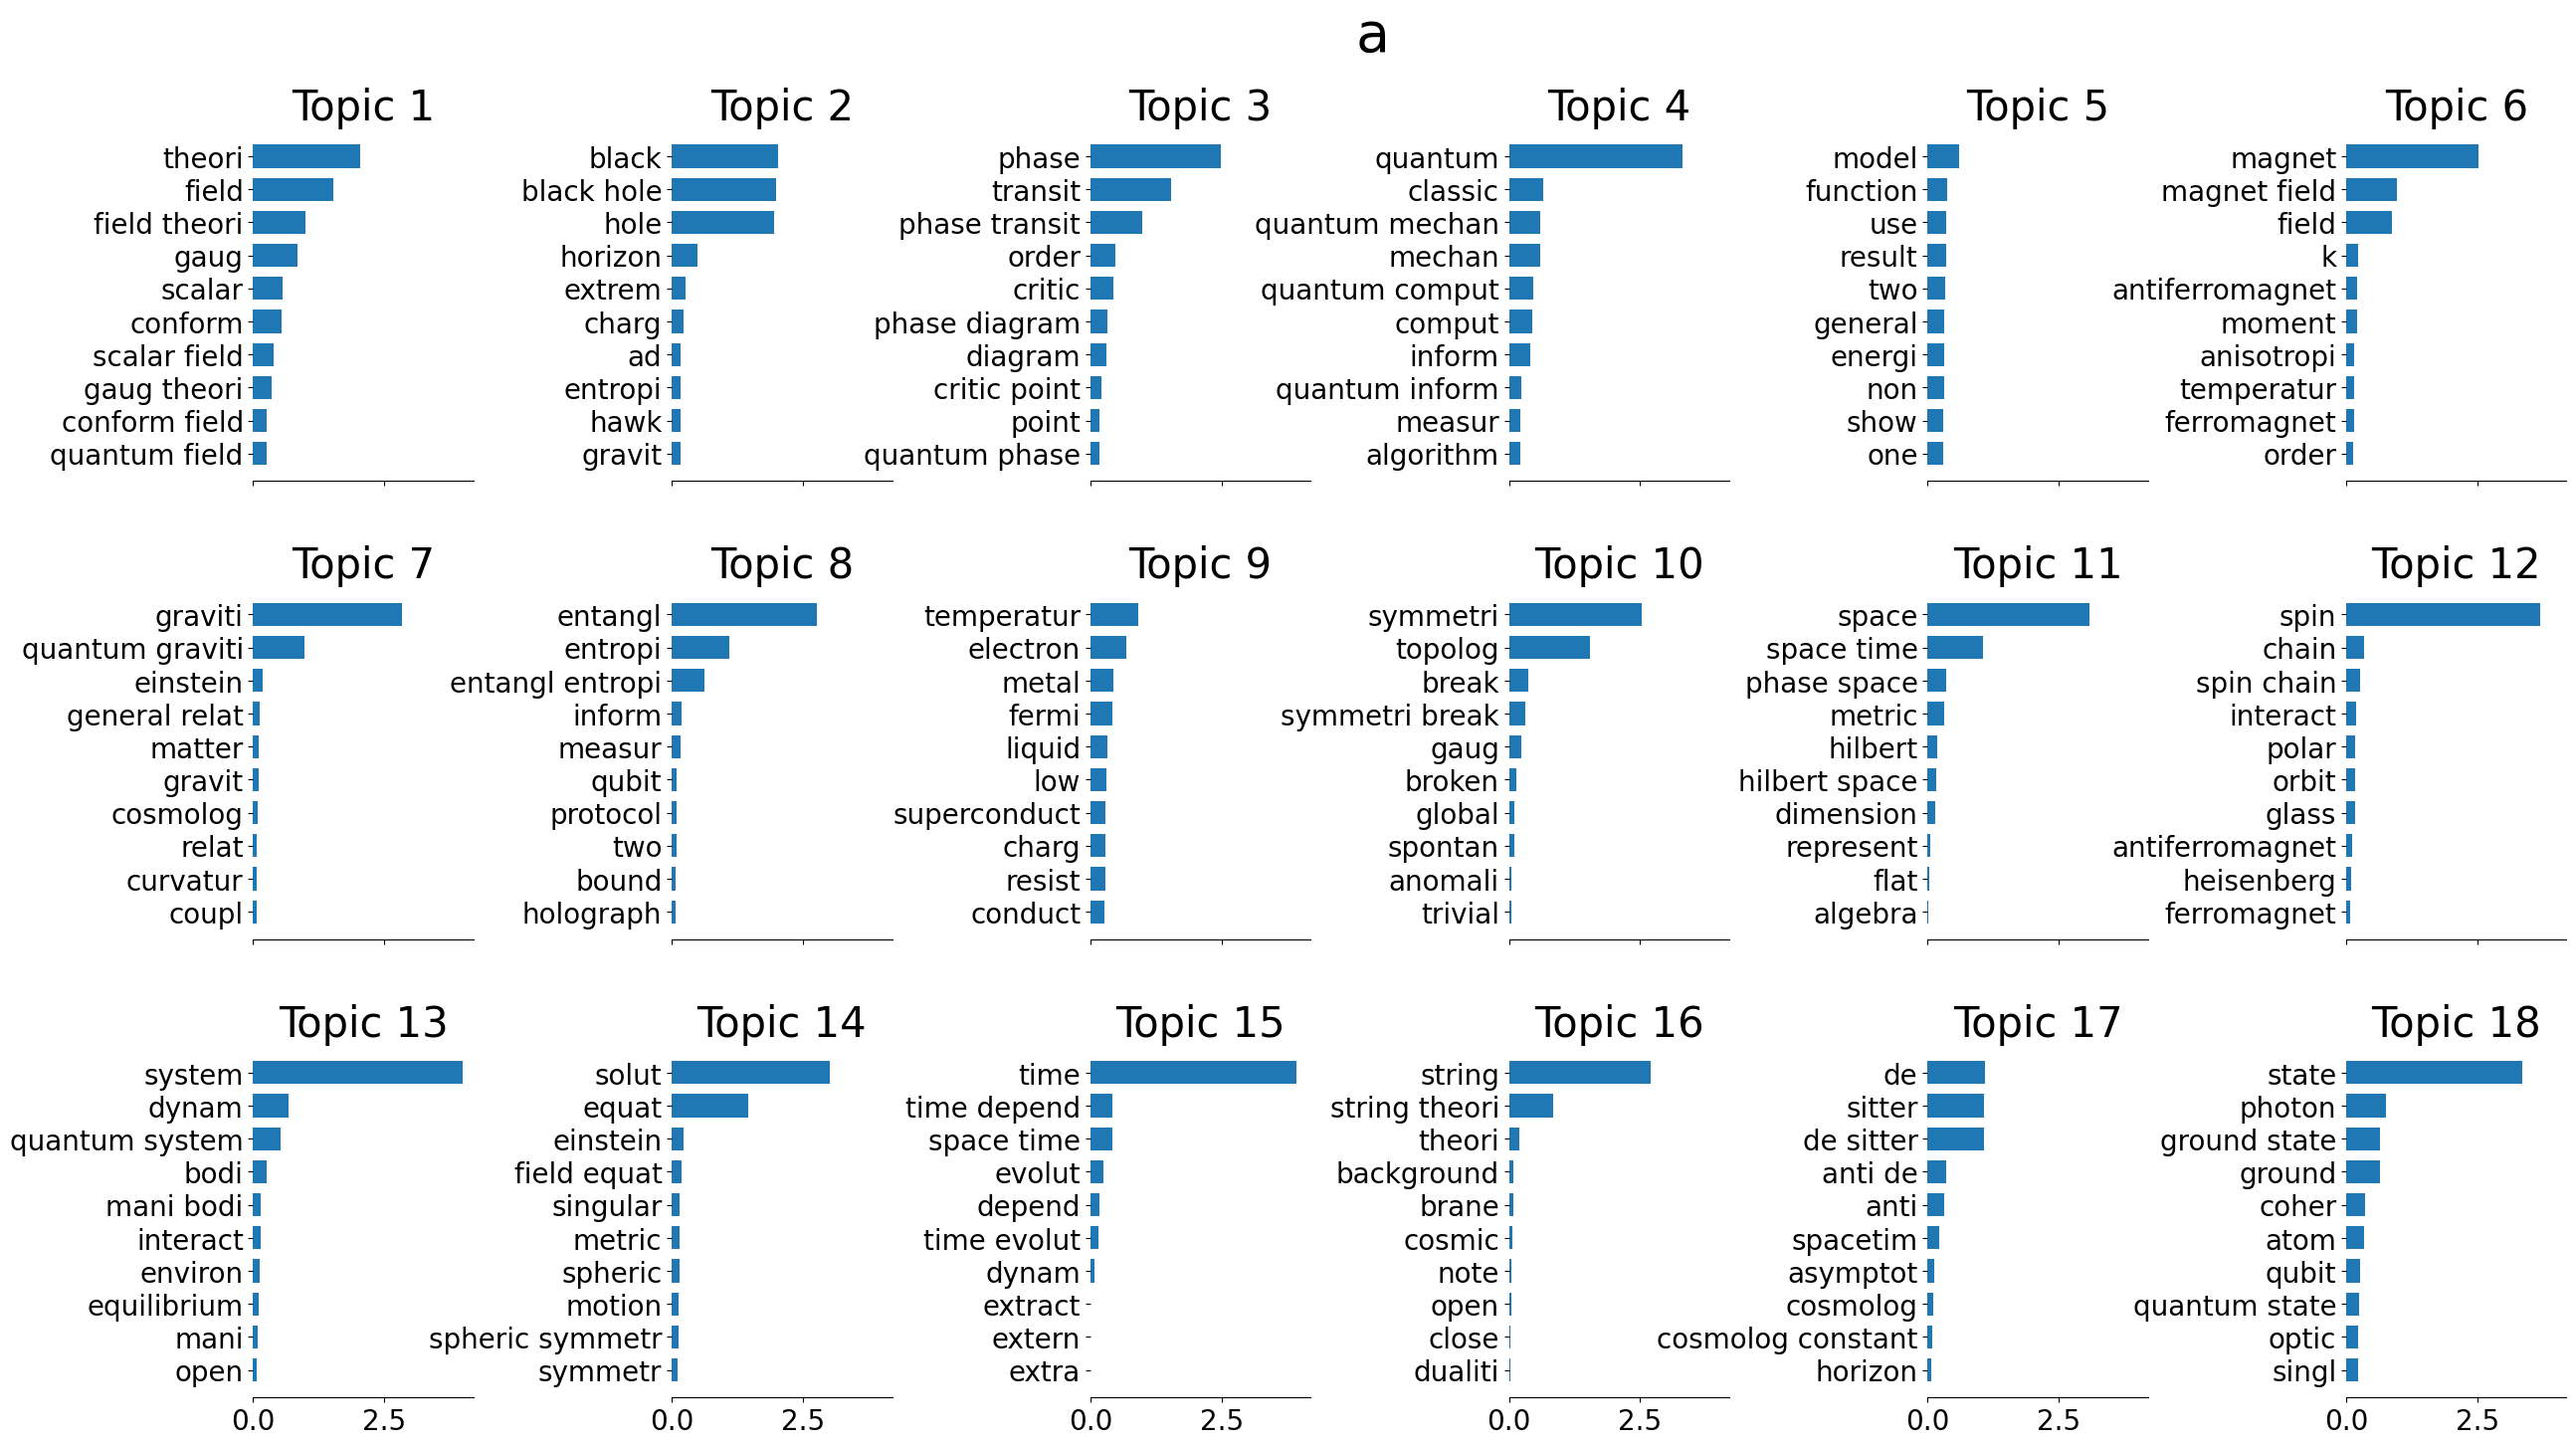

In [6]:
nmf = NMF(
    n_components=18,
    random_state=0,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
    init="nndsvda",
).fit(Xsummary)

plots.plot_top_words(nmf, cvSummary.get_feature_names_out(), title="a", nrows_cols=(3, 6), n_top_words=10)

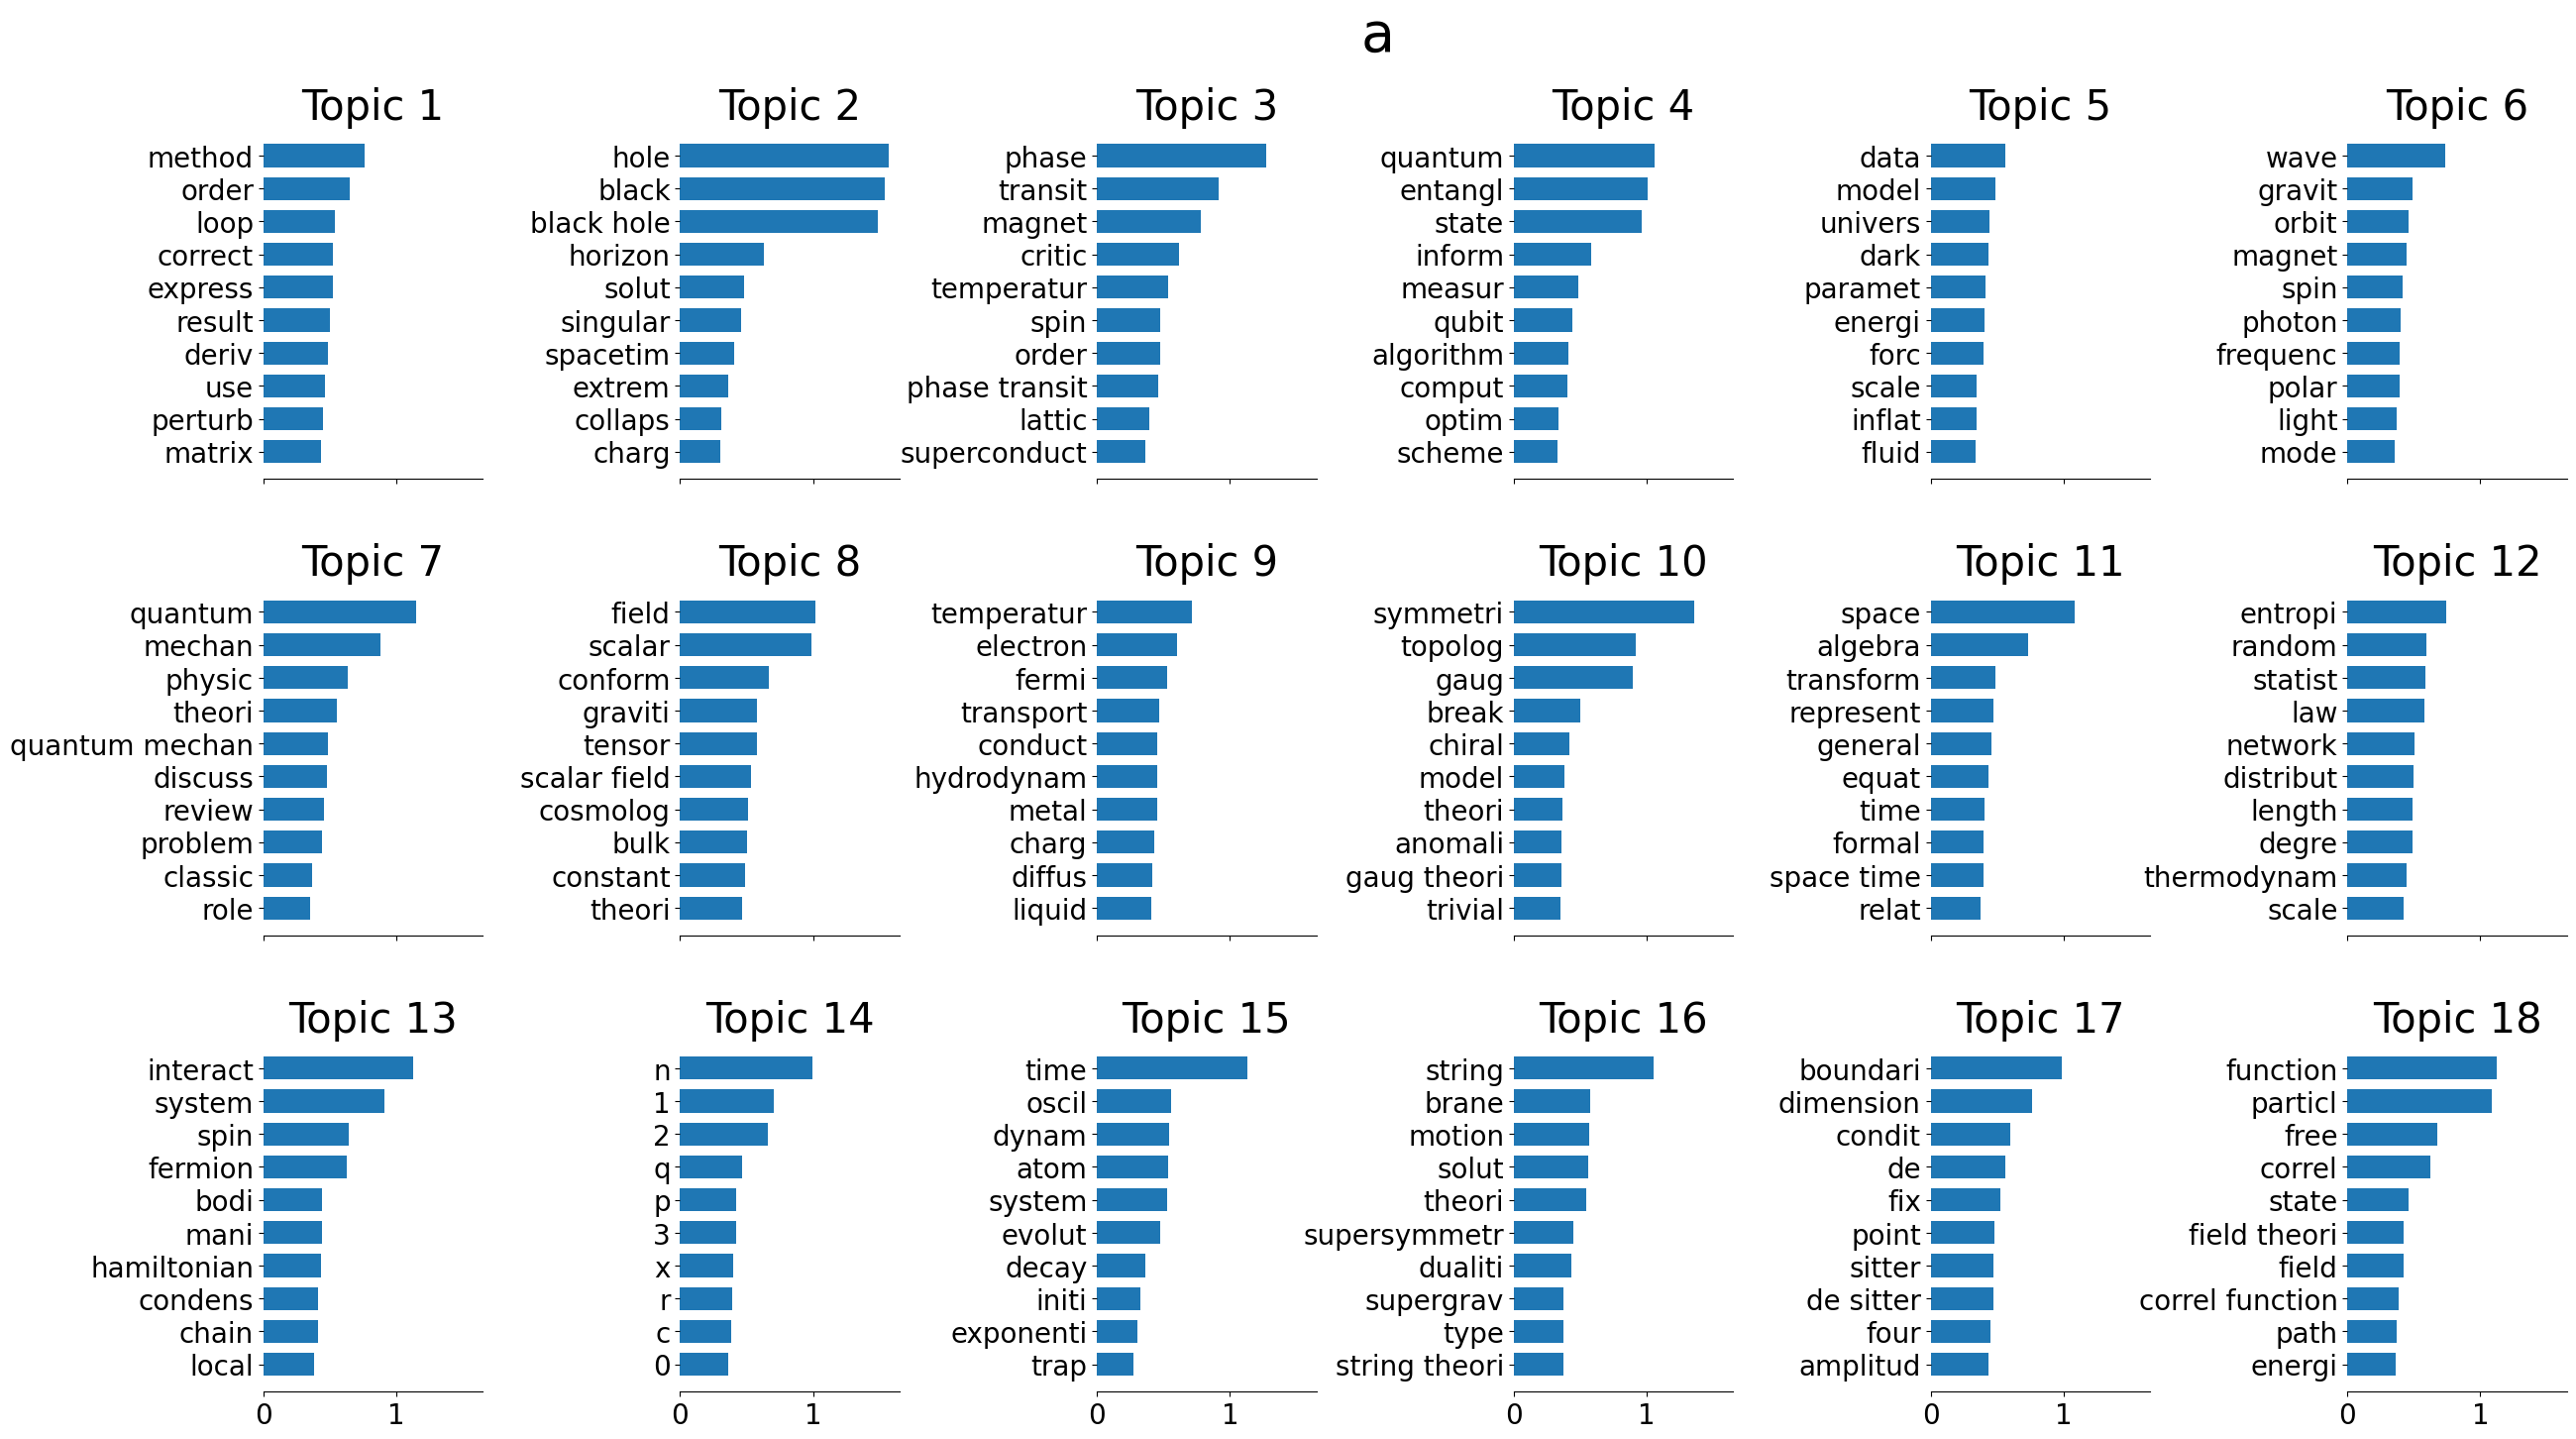

In [7]:
nmf2 = NMF(
    n_components=18,
    random_state=0,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
    init="nndsvda",
).fit(Xsummary)

plots.plot_top_words(nmf2, cvSummary.get_feature_names_out(), title="a", nrows_cols=(3, 6), n_top_words=10)

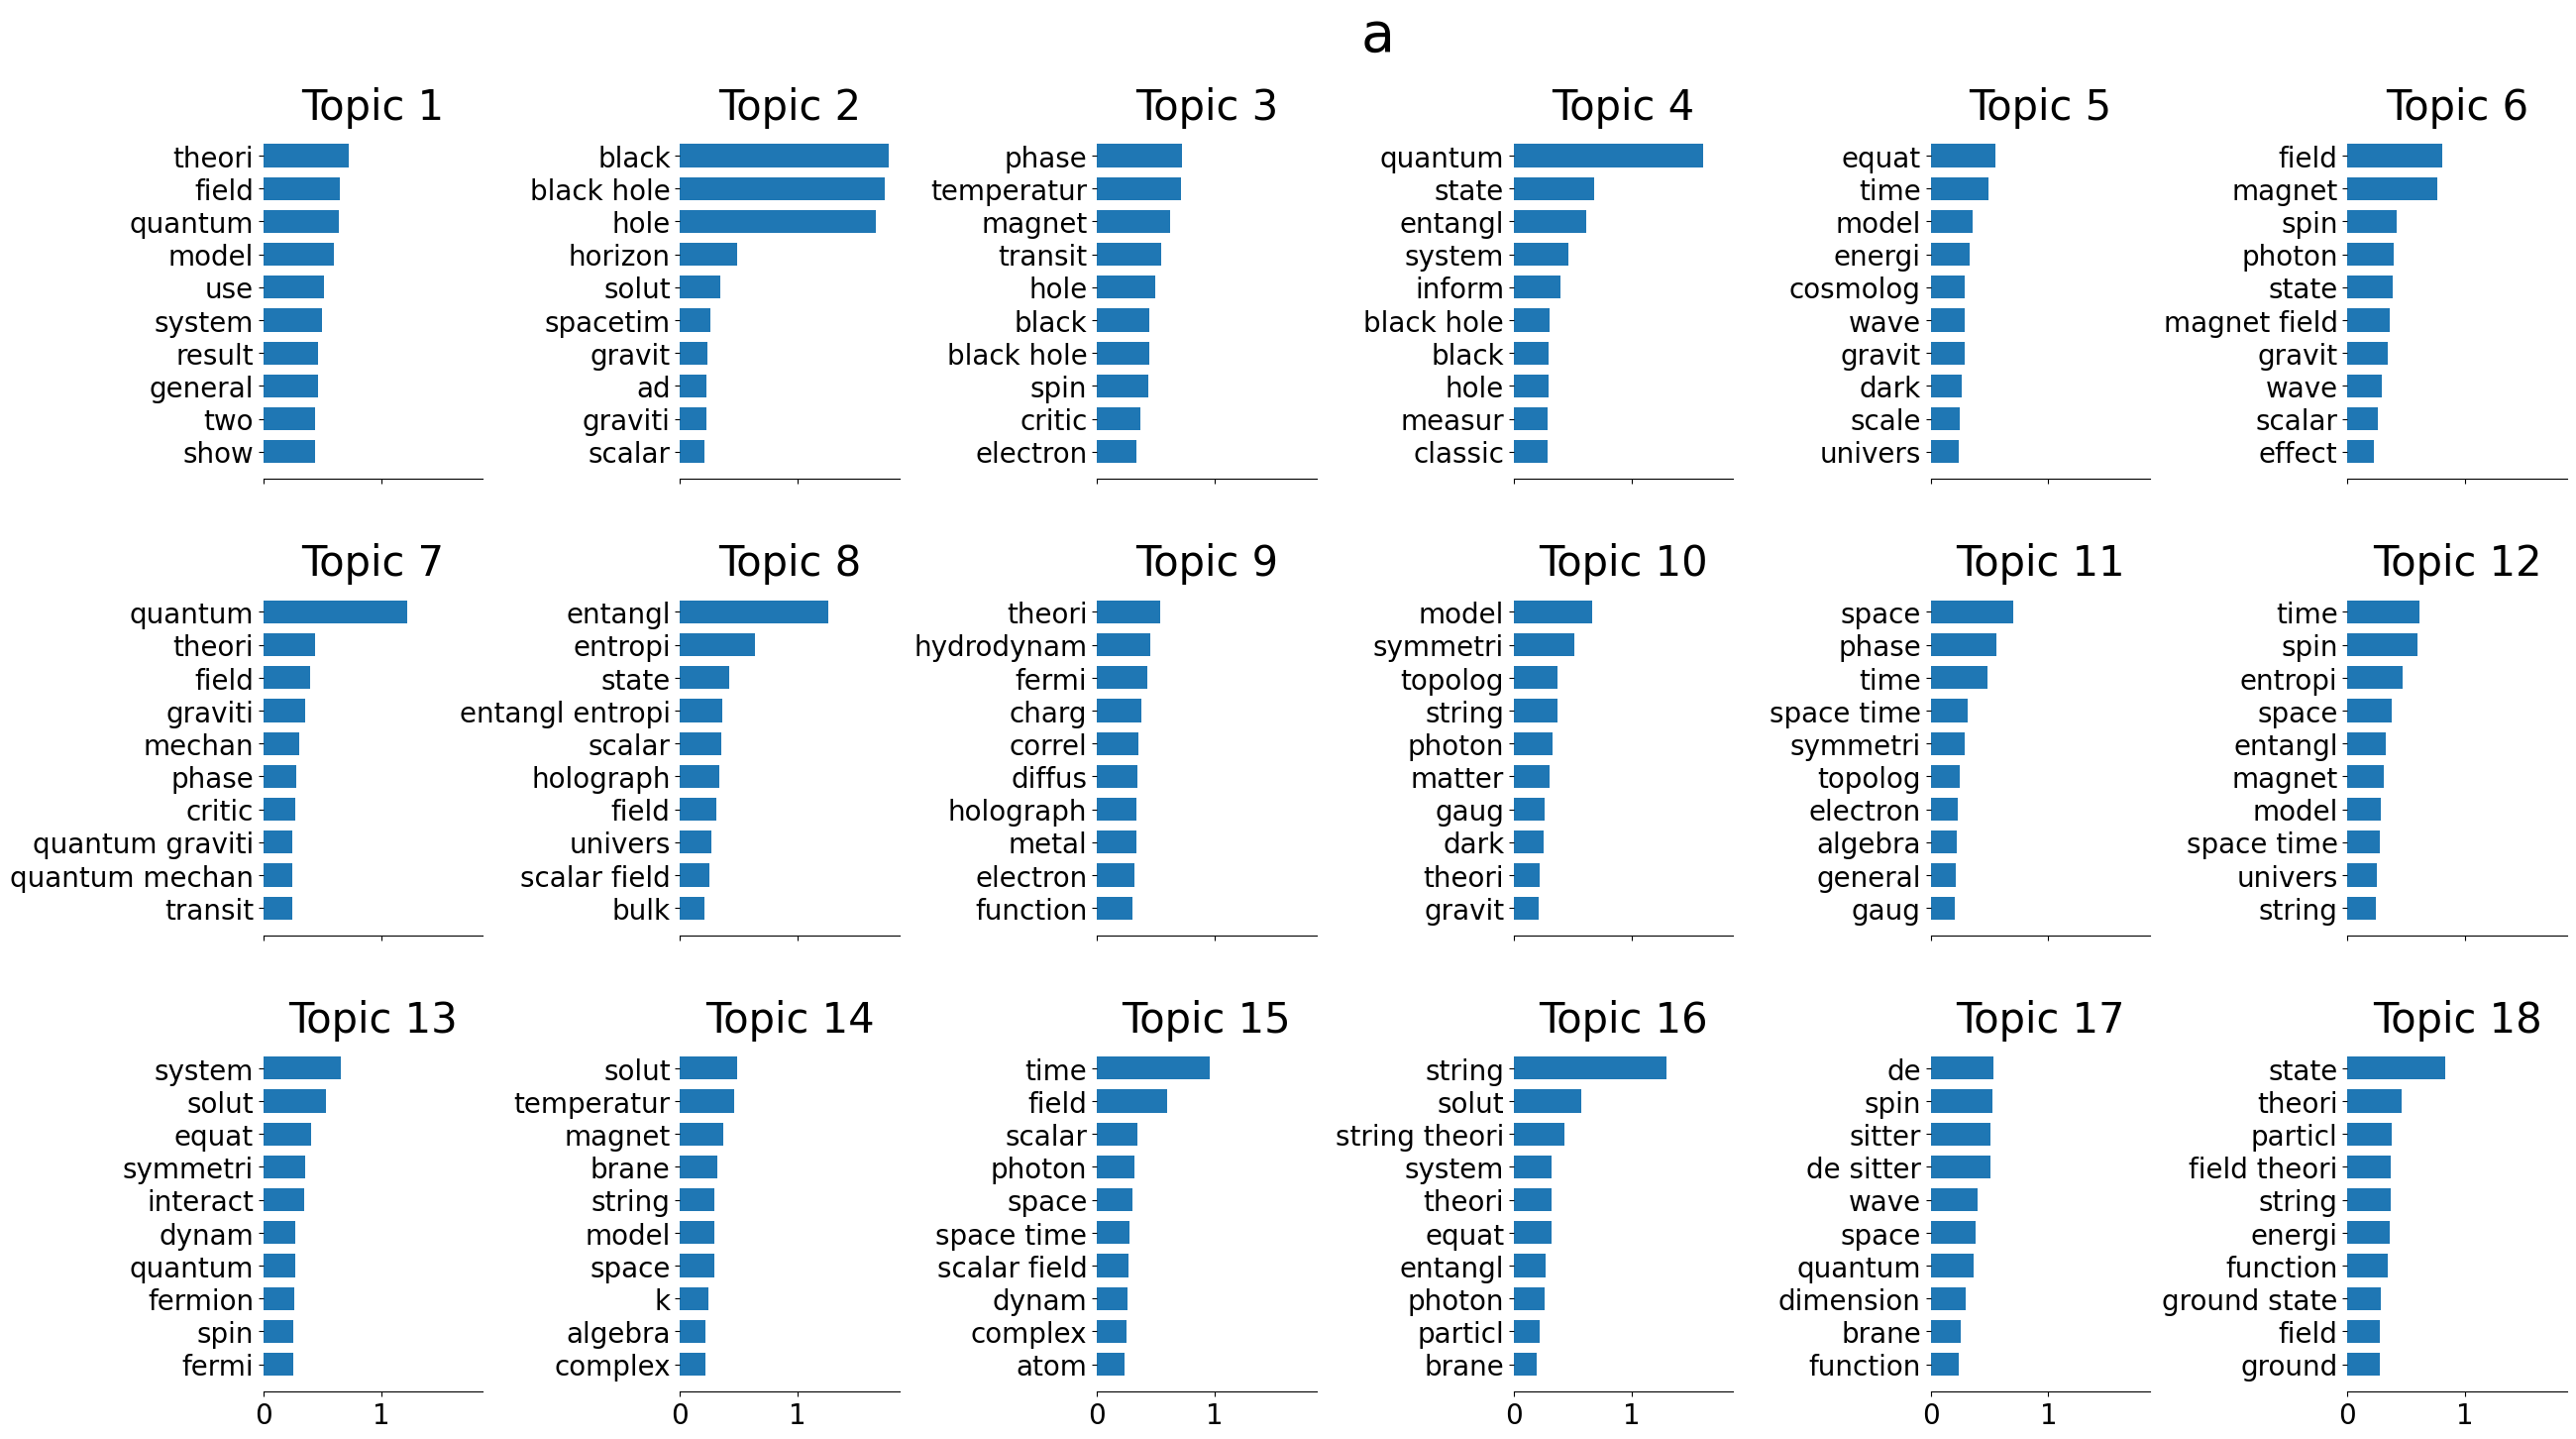

In [8]:
mbnmf = MiniBatchNMF(
    n_components=18,
    random_state=0,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    batch_size=128,
    l1_ratio=0.5,
    init="nndsvda",
).fit(Xsummary)

plots.plot_top_words(mbnmf, cvSummary.get_feature_names_out(), title="a", nrows_cols=(3, 6), n_top_words=10)

We will now use these topics to label each author. Now for each author, we will make an average topic vector. The authors category will then be encoded as a list of n-most important topics.

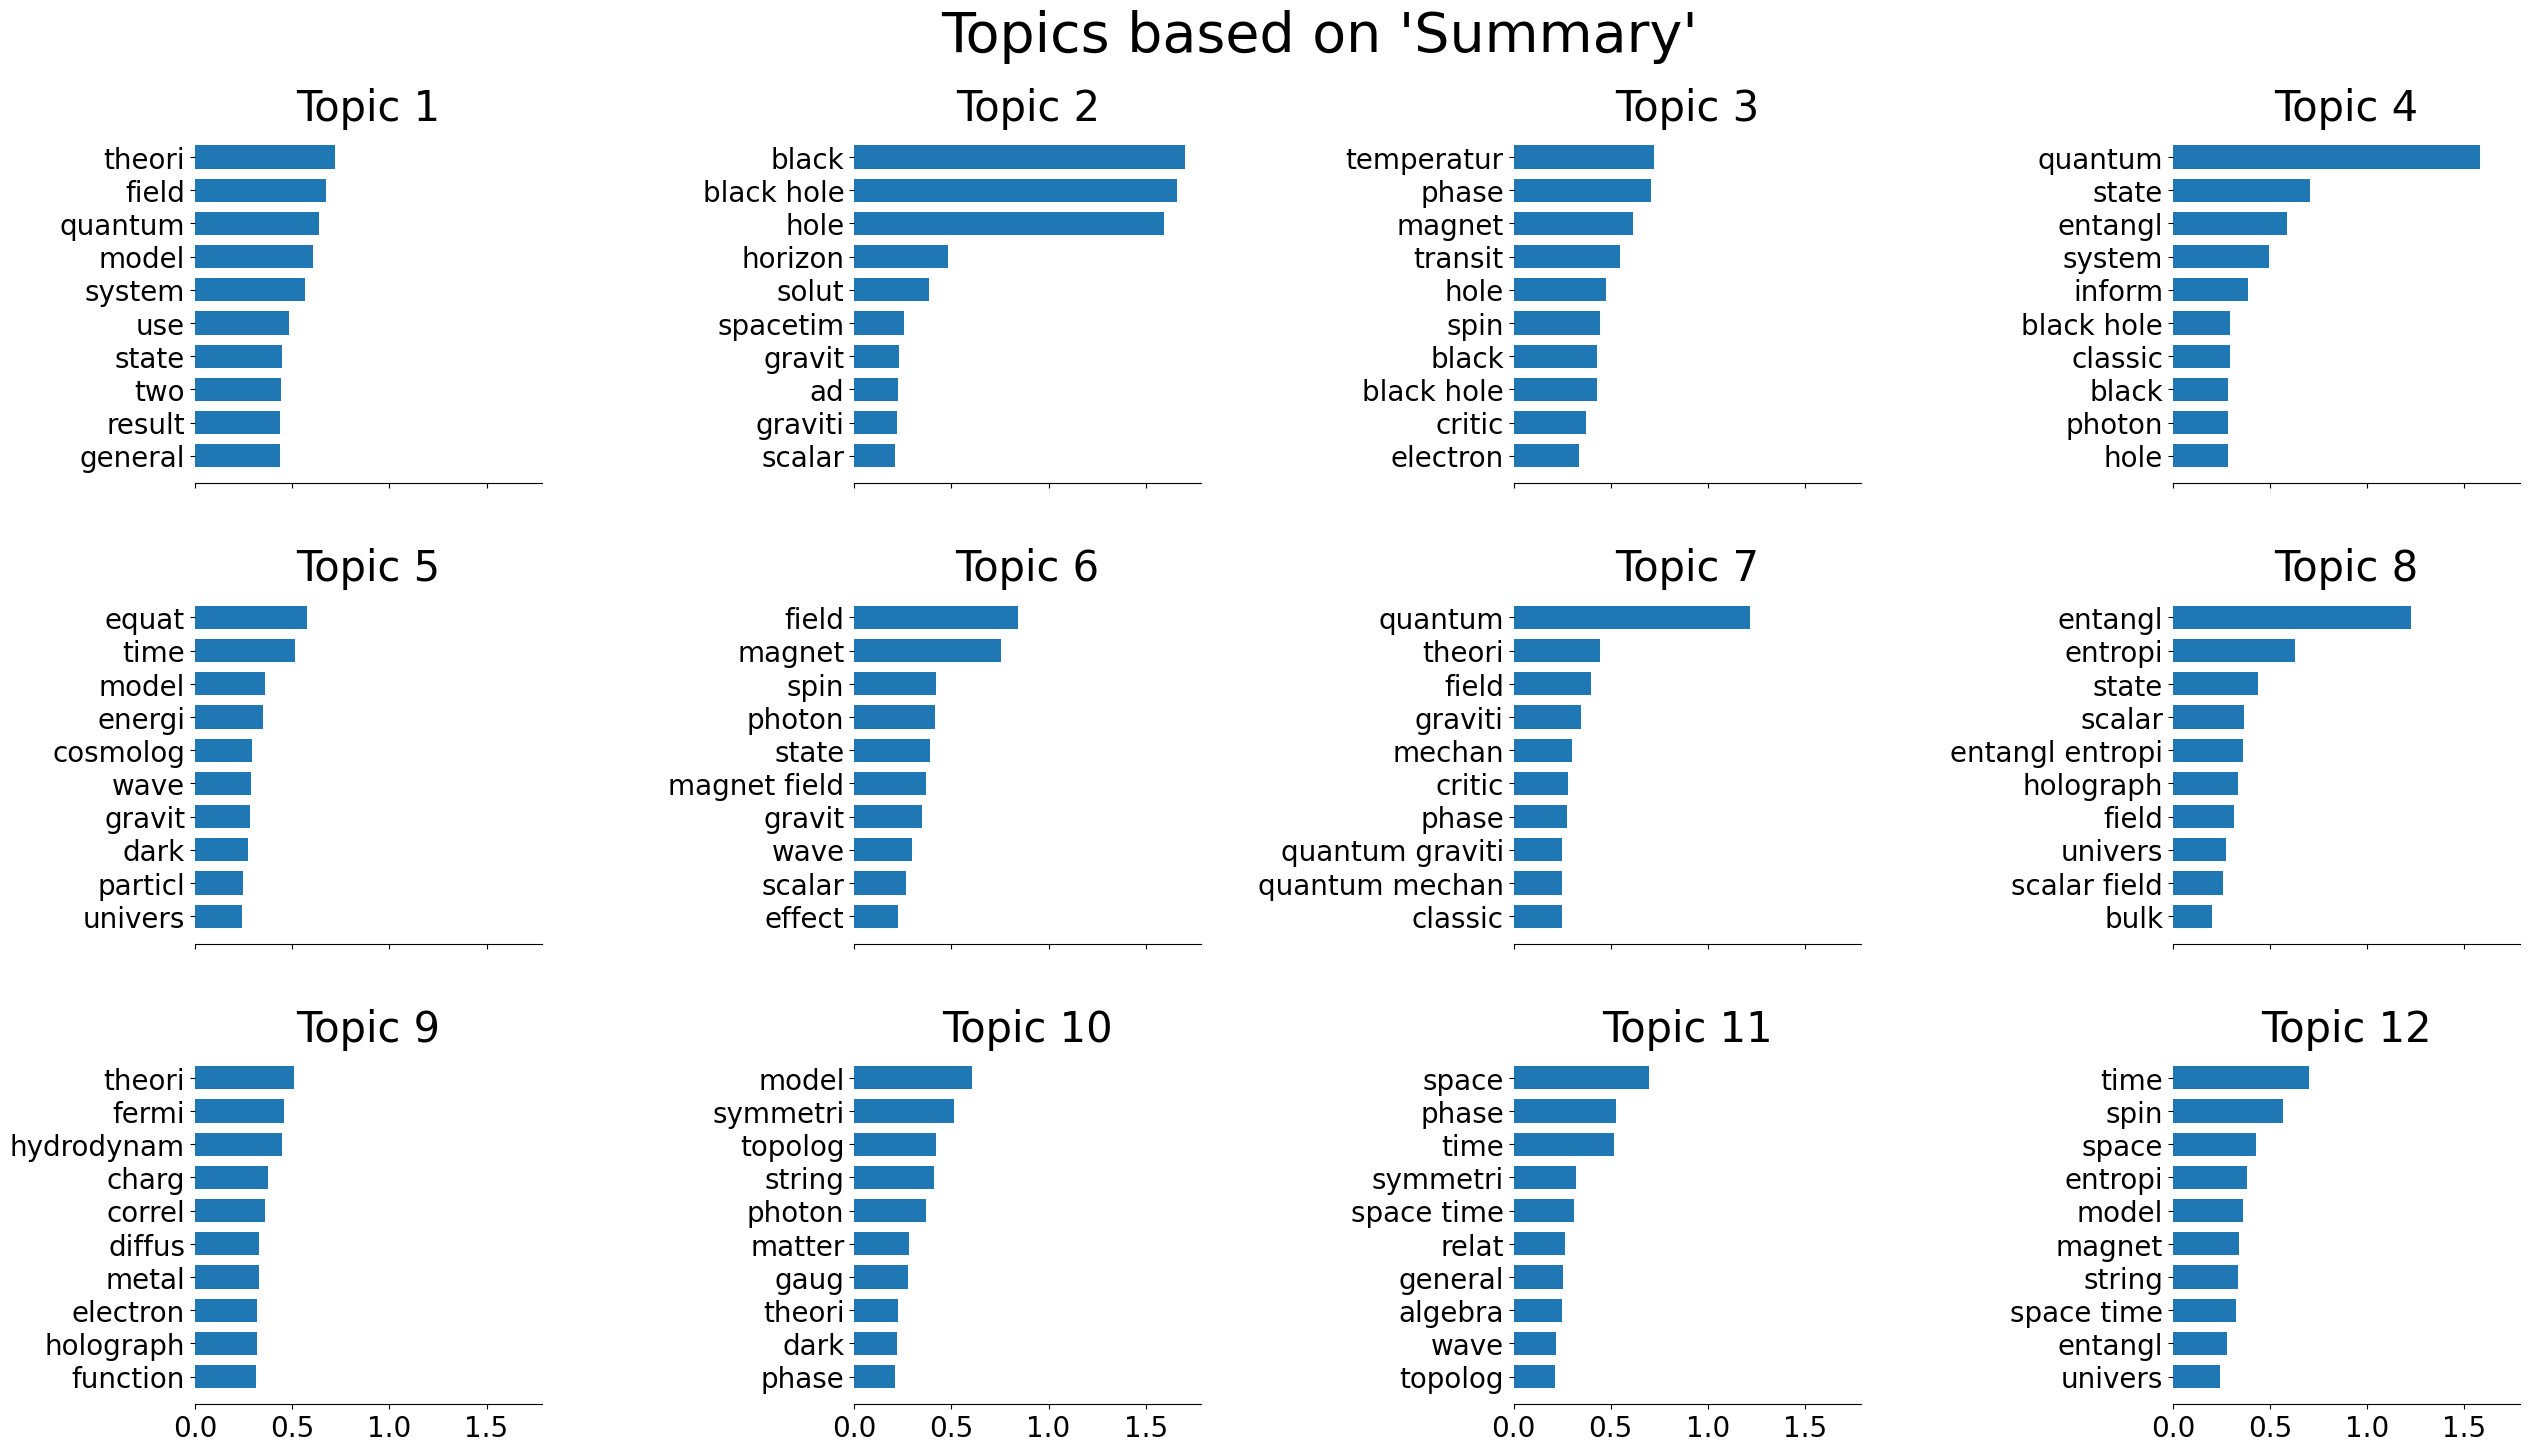

In [29]:
mbnmf = MiniBatchNMF(
    n_components=12,
    random_state=0,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    batch_size=128,
    l1_ratio=0.5,
    init="nndsvda",
).fit(Xsummary)

plots.plot_top_words(
    mbnmf, cvSummary.get_feature_names_out(), title="Topics based on 'Summary'", nrows_cols=(3, 4), n_top_words=10
)

We see that we can separate the most used characters in various topics. This is a property of the non-negative matrix factorization which can easily yield the result of a KMeans Clustering algorithm.

We can now encode each author by a sequence of topics, with multiple authors leading to concatenated sequences. Therefore, for a given paper, the common topics of the authors will have the most weight. But first we need to precompute the list of topics for each author which we then save to a file.

In [14]:
# y = feature_engineering.build_authors_topics_series(all_df_clean)
y = pd.read_csv(config.path_data_author_encoding, index_col=0)

We can see the topic 1 will not be very useful so we should also use Tfidf on this new feature.

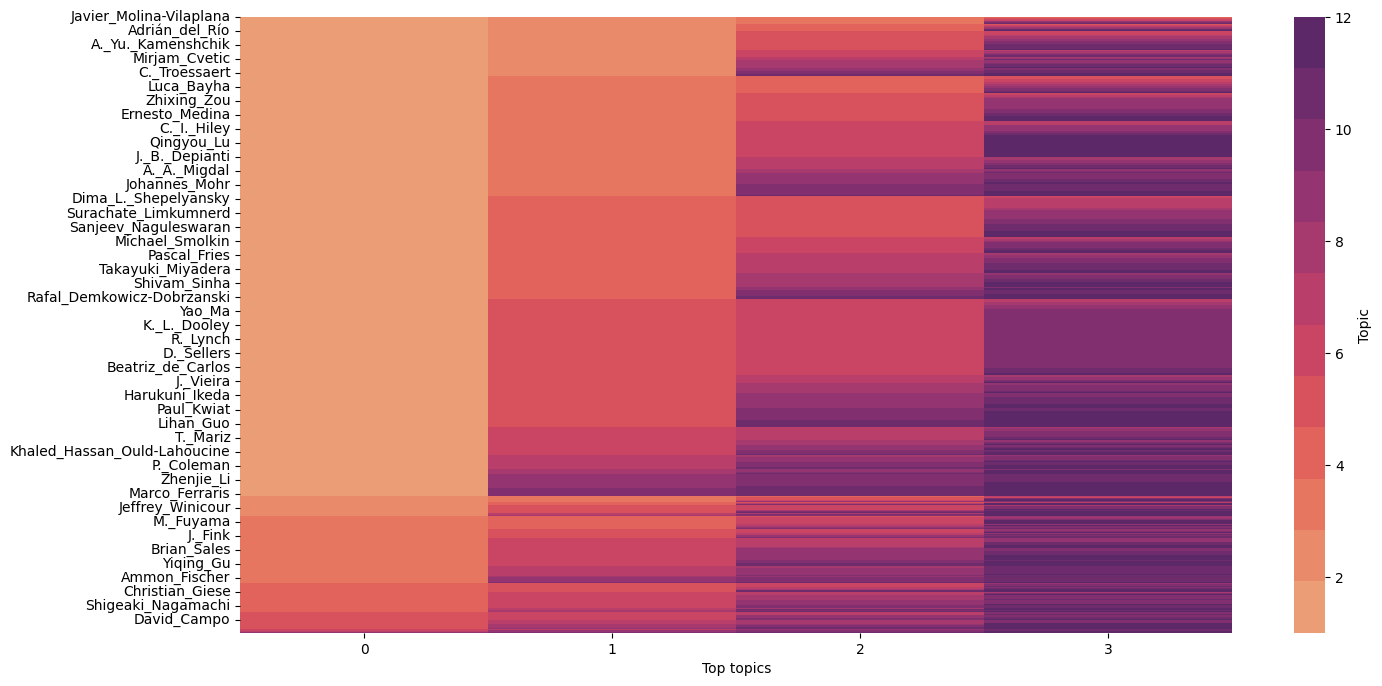

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
cmap = sns.color_palette("flare", 12)
sns.heatmap(
    y[["0", "1", "2", "3"]].sort_values(by=["0", "1", "2", "3"]), ax=ax, cbar_kws={"label": "Topic"}, cmap=cmap
)
ax.set_xlabel("Top topics")
fig.savefig(config.path_figs / "heatmap_topics.png", dpi=300)

In [39]:
y2 = y.copy()
for i in range(1, 13):
    y2[f"topic_{i}"] = y2.apply(lambda x: str(i) in x["concat_topics"], axis=1)

In [65]:
y2.iloc[4800:4850]

,0,1,2,3,concat_topics,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
K._Haughian,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
J._Healy,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
A._Heidmann,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
M._C._Heintze,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
H._Heitmann,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
P._Hello,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
G._Hemming,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
M._Hendry,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
I._S._Heng,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False
J._Hennig,1,5,6,10,1 5 6 10,True,False,False,False,True,True,False,False,False,True,False,False


Text(144.44444444444446, 0.5, 'Authors')

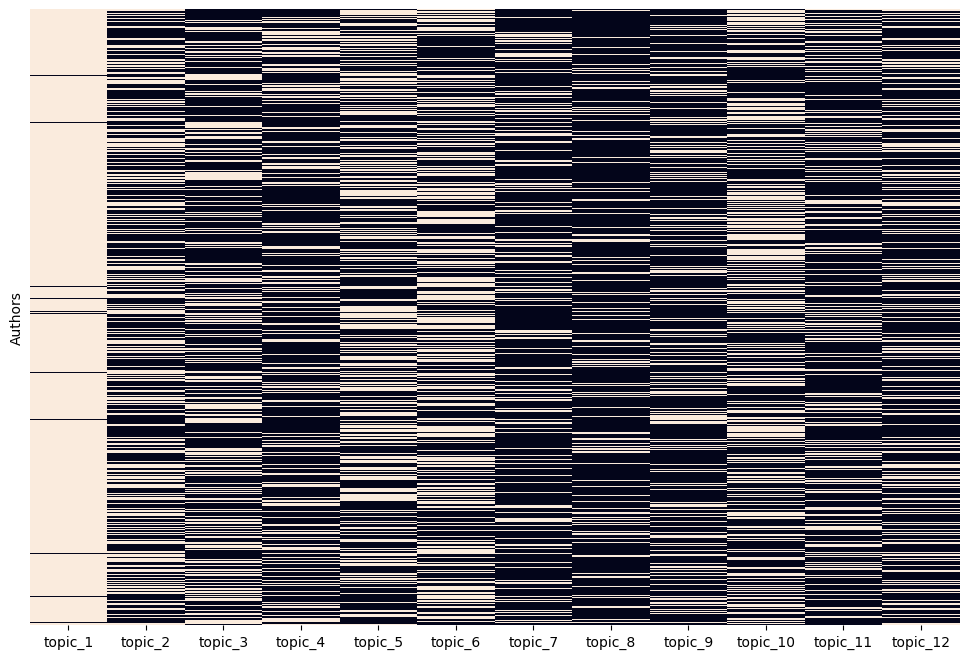

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(y2.sort_index().reset_index()[[f"topic_{i}" for i in range(1, 13)]], cbar=False, ax=ax, yticklabels=[])
ax.set_ylabel("Authors")

We can now make some recommendations! We just have to create the encoded feature and use it instead of the authors column.

In [69]:
# Define features, encode data
all_df_fe = feature_engineering.CreateAuthorsTopicsFeature().fit_transform(all_df_clean)

cvMixedEncoding = preprocessing.cvMixedEncoding
cos_mat_mixed_encoding, X_processed_encoding = recommender.build_similarity_matrix(all_df_fe, cvMixedEncoding)

In [70]:
# List of my papers
my_papers = [574, 33, 580]

In [71]:
recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_mixed_encoding], n_recommendations=15).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.443022
1,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.344177
2,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.321396
3,Quantum Criticality and Holographic Supercondu...,Jerome Gauntlett ; Julian Sonner ; Toby Wiseman,hep-th,0912.0512,0.311076
4,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.309276
5,Thermal conductivity at a disordered quantum c...,Sean A. Hartnoll ; David M. Ramirez ; Jorge E....,hep-th cond-mat.str-el gr-qc,1508.04435,0.295774
6,Generalized Holographic Quantum Criticality at...,B. Goutéraux ; E. Kiritsis,hep-th cond-mat.str-el gr-qc,1107.2116,0.293883
7,Slow relaxation and diffusion in holographic q...,Richard A. Davison ; Simon A. Gentle ; Blaise ...,hep-th cond-mat.str-el,1808.05659,0.292652
8,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.291844
9,Semi-local quantum liquids,Nabil Iqbal ; Hong Liu ; Mark Mezei,hep-th cond-mat.str-el,1105.4621,0.288012


In [72]:
recommender.get_similar_entries_entry(all_df, my_papers[1], [cos_mat_mixed_encoding], n_recommendations=15).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Hydrodynamics of ideal fracton fluids,Kevin T. Grosvenor ; Carlos Hoyos ; Francisco ...,cond-mat.str-el cond-mat.quant-gas cond-mat.st...,2105.01084,0.280730
1,Quasinormal modes in charged fluids at complex...,Aron Jansen ; Christiana Pantelidou,hep-th,2007.14418,0.280313
2,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.275210
3,Two-dimensional hydrodynamic electron flow thr...,Aaron Hui ; Calvin Pozderac ; Brian Skinner,cond-mat.str-el cond-mat.mes-hall,2309.15917,0.264404
4,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.253430
5,Hydrodynamics of dipole-conserving fluids,Aleksander Głódkowski ; Francisco Peña-Benítez...,cond-mat.str-el cond-mat.soft cond-mat.stat-me...,2212.06848,0.247107
6,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.235070
7,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.231055
8,Lectures on hydrodynamic fluctuations in relat...,Pavel Kovtun,hep-th,1205.5040,0.221593
9,Fracton hydrodynamics,Andrey Gromov ; Andrew Lucas ; Rahul M. Nandki...,cond-mat.str-el cond-mat.stat-mech hep-th quan...,2003.09429,0.216253
